<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈️ **GoFly Predicción de Retrasos Aéreos**

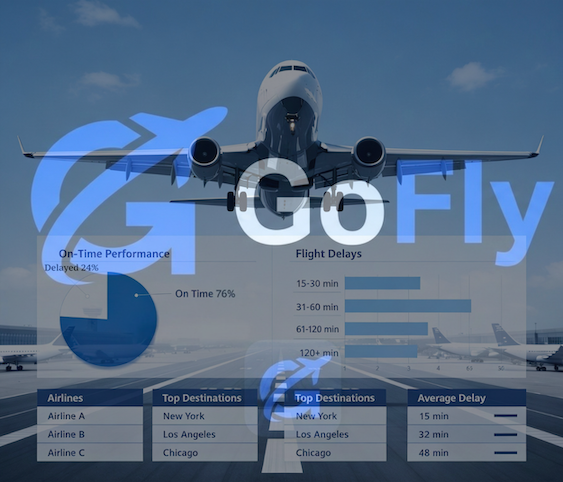

# Introducción al notebook: predicción de retrasos de vuelos

Este proyecto busca anticipar el riesgo de retraso, permitiendo tomar decisiones preventivas y mejorar la planificación operativa por medio de desarrollo y evalución de modelos de Machine Learning capaces de predecir si un vuelo despegará puntual o con retraso, usando información disponible antes del vuelo. El resultado es un modelo listo para ser consumido por una API REST, permitiendo su uso en tiempo real por aerolíneas, aeropuertos o sistemas externos.

Dado que el proyecto creció en tamaño y complejidad, y para mantener un flujo de trabajo más estable, reproducible y fácil de mantener, el notebook se dividió en dos partes:

> 1. Un notebook `kaggle_notebook_clima.ipynb` de procesamiento en Kaggle, que obtiene la información base de vuelos y la enriquece con datos de ubicación de aeropuertos y clima histórico.
>
> 2. Este mismo notebook `flightontime_hackaton_e32_alura_latam.ipynb` de procesamiento en Colab, está orientado al entrenamiento y enfocado en la exploración de variables, gráficos, limpieza, modelado, validación, visualización de resultados y ajuste de métricas. De esta manera, se reduce la probabilidad de errores y se acelera la experimentación.


Se abordan las fases clave de un proyecto de ciencia de datos:

1.  **Carga y Exploración de Datos:** se carga un dataset que combina información de vuelos con datos meteorológicos.
2.  **Preprocesamiento de Datos:** se limpian los datos, se manejan valores nulos y se transforman las variables para hacerlas aptas para los modelos.
3.  **Entrenamiento y Evaluación de Modelos:** se construyen y entrenan dos tipos de modelos: Regresión Logística (un modelo base simple) y Random Forest (un modelo de conjunto más avanzado). Ambos se evalúan utilizando métricas como el Classification Report, ROC AUC y Matrices de Confusión.
4.  **Simulación de Predicciones:** se crea una función que simula un "endpoint" de API para realizar predicciones con nuevos datos, mostrando cómo se usaría el modelo en un entorno real.
5.  **Análisis de Resultados y Conclusiones:** se analizan los resultados de los modelos, se visualizan su rendimiento y se extraen conclusiones sobre cuál es el mejor modelo para el caso de uso, junto con posibles mejoras futuras.

Para abrir el notebook `kaggle_notebook_clima.ipynb` en Kaggle:
1. Ir a [Kaggle](https://www.kaggle.com)
2. Click **Code** (menú superior)
3. Click botón **New Notebook**
4. En el notebook nuevo:
   - Click menú **File** → **Import Notebook**
5. Seleccionar pestaña **GitHub**
6. Pegar URL del notebook:
   https://github.com/sunnyday2/flight_on_time/blob/main/kaggle_notebook_clima.ipynb
7. Click **Import**

## Definición del problema de data science

Tipo de problema: clasificación binaria

Variable objetivo:

*   `delayed=0` → Vuelo puntual
*   `delayed=1` → Vuelo retrasado

Pregunta que responde el modelo:

¿Este vuelo tiene una alta probabilidad de retrasarse?

---------

# **1. 📚 Librerías y configuración**
---

## Consolidar todas las librerías en una sola sección para evitar *imports* repetidos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    auc,
    average_precision_score,
    precision_recall_curve
)
from scipy.stats import randint
from scipy import sparse
import joblib
import os

sns.set(style="whitegrid")

# **2. 📥 Cargar el dataset enriquecido**
---

### Leer archivo desde GitHub


Cargamos el dataset principal que contiene la información de vuelos combinada con datos climáticos. El dataset se obtiene directamente desde una URL en GitHub.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/sunnyday2/flight_on_time/desarrollo/dataset_vuelos_clima_final.csv")

# **3. 👀 Inspección visual de los datos**
---


### Visualizar las primeras 5 filas.

 Después de cargar los datos en un DataFrame de pandas, se muestran las dimensiones del DataFrame (df.shape) y las primeras filas (df.head()) para una inspección rápida y verificar la estructura de los datos.

In [ ]:
df.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,city_clean,state_clean,type,name,latitude,longitude,airport_code,temp_mean,precipitation,wind_speed
0,2018,1,30,2018-01-30,WN,"Denver, CO","Oakland, CA",2200,2155.0,-5.0,...,Denver,CO,medium_airport,Rocky Mountain Metropolitan Airport,39.908798,-105.116997,BJC,7.40,0.0,20.4
1,2018,1,25,2018-01-25,AA,"Denver, CO","Dallas/Fort Worth, TX",1935,1930.0,-5.0,...,Denver,CO,medium_airport,Rocky Mountain Metropolitan Airport,39.908798,-105.116997,BJC,-1.50,0.0,16.6
2,2018,1,11,2018-01-11,UA,"Houston, TX","Santa Ana, CA",1830,2149.0,199.0,...,Houston,TX,large_airport,George Bush Intercontinental Houston Airport,29.984400,-95.341400,IAH,11.10,13.5,32.6
3,2018,10,30,2018-10-30,UA,"Denver, CO","Minneapolis, MN",2030,2023.0,-7.0,...,Denver,CO,medium_airport,Rocky Mountain Metropolitan Airport,39.908798,-105.116997,BJC,4.50,8.7,14.0
4,2018,10,25,2018-10-25,DL,"Lexington, KY","Washington, DC",615,614.0,-1.0,...,Lexington,KY,medium_airport,Blue Grass Airport,38.036499,-84.605904,LEX,8.55,0.0,12.1


### Revisar cuántas filas y columnas hay

In [ ]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (17450, 43)


### Qué tipo de datos contiene cada una: ¿son números, fechas, texto?

In [ ]:
df.dtypes

,0
year,int64
month,int64
dayofmonth,int64
flightdate,object
marketing_airline_network,object
origincityname,object
destcityname,object
crsdeptime,int64
deptime,float64
depdelay,float64


### **Estadística básica**

Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [ ]:
df.describe()

,year,month,dayofmonth,crsdeptime,deptime,depdelay,depdelayminutes,taxiout,wheelsoff,wheelson,...,securitydelay,lateaircraftdelay,hour,delayed,day_of_week,latitude,longitude,temp_mean,precipitation,wind_speed
count,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,...,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000,17450.000000
mean,2020.505043,7.084871,15.797765,1335.262636,1338.010143,10.032321,13.603209,17.217479,1363.390372,1475.996390,...,0.018911,4.944756,13.081089,0.170946,2.940917,37.378426,-93.640742,9.409043,2.806688,19.376814
std,1.716146,4.607385,8.793559,484.212673,496.997226,52.395534,51.322870,9.723791,497.618945,522.570624,...,0.804372,24.273478,4.822948,0.376472,1.996129,5.866859,17.026667,8.783034,6.913598,7.407777
min,2018.000000,1.000000,1.000000,1.000000,1.000000,-38.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19.721350,-165.445007,-31.100000,0.000000,4.600000
25%,2019.000000,2.000000,8.000000,925.000000,926.000000,-6.000000,0.000000,11.000000,942.250000,1101.000000,...,0.000000,0.000000,9.000000,0.000000,1.000000,33.636700,-105.116997,3.350000,0.000000,13.700000
50%,2021.000000,10.000000,16.000000,1326.000000,1329.000000,-3.000000,0.000000,15.000000,1343.000000,1507.000000,...,0.000000,0.000000,13.000000,0.000000,3.000000,38.852100,-87.752403,9.450000,0.000000,18.200000
75%,2022.000000,11.000000,23.000000,1740.000000,1746.000000,4.000000,4.000000,20.000000,1802.000000,1915.750000,...,0.000000,0.000000,17.000000,0.000000,5.000000,41.411701,-81.119499,15.650000,1.800000,23.700000
max,2023.000000,12.000000,31.000000,2359.000000,2400.000000,1559.000000,1559.000000,149.000000,2400.000000,2400.000000,...,60.000000,657.000000,23.000000,1.000000,6.000000,70.194702,-68.828102,32.150000,130.100000,77.500000



---

> **Aquí se presentan las estadísticas clave**:
>
> - **count (conteo)**: confirma la completitud de los datos (sin nulos en estas columnas).
>
> - **mean y median (50%)**: comparar estos valores ayuda a identificar el sesgo de la distribución. Si la media es significativamente mayor que la mediana, sugiere un sesgo positivo (cola larga hacia la derecha), como es el caso de los retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`), indicando que la mayoría de los vuelos salen/llegan a tiempo o antes, pero hay algunos retrasos muy largos que suben la media.
> - **std (desviación estándar)**: mide la dispersión de los datos. Un `std` alto en relación con la `mean` (como en `depdelay`) indica una gran variabilidad, lo que significa que los valores individuales se desvían mucho del promedio. Esto es crucial para entender la imprevisibilidad de los retrasos.
> - **min y max**: revelan el rango completo de los datos y la presencia de valores extremos. Por ejemplo, `min` negativos para `depdelay` y `depdelayminutes` indican vuelos que salieron antes de lo programado. `max` muy altos en los retrasos confirman la existencia de *outliers* o eventos de retraso muy significativos. El `max` de `distance` muestra vuelos de muy larga distancia.
> - **cuartiles (25%, 50%, 75%)**: proporcionan una visión de la distribución interna de los datos. Por ejemplo, para los retrasos, un 75% bajo (o incluso negativo) sugiere que la mayoría de los vuelos se ajustan a un horario puntual, y los retrasos significativos son menos frecuentes, pero potentes. En `distance`, muestran cómo se distribuyen las distancias de vuelo típicas.



# **4. 🧹 Limpieza y preparación de datos**
---

### **Valores faltantes**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17450 entries, 0 to 17449
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       17450 non-null  int64  
 1   month                      17450 non-null  int64  
 2   dayofmonth                 17450 non-null  int64  
 3   flightdate                 17450 non-null  object 
 4   marketing_airline_network  17450 non-null  object 
 5   origincityname             17450 non-null  object 
 6   destcityname               17450 non-null  object 
 7   crsdeptime                 17450 non-null  int64  
 8   deptime                    17450 non-null  float64
 9   depdelay                   17450 non-null  float64
 10  depdelayminutes            17450 non-null  float64
 11  taxiout                    17450 non-null  float64
 12  wheelsoff                  17450 non-null  float64
 13  wheelson                   17450 non-null  flo

---
> Según la salida de `df.info()`, todas las columnas en ese conjunto de datos muestran un conteo de no nulos de 17.450, lo que coincide con el índice de rango total de 17.450 entradas. Esto significa que no hay valores faltantes en este DataFrame. Por lo tanto, no es necesario tomar ninguna medida para eliminar filas o llenar espacios vacíos.

### **Duplicados**

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


---
> La salida muestra: `"Número de filas duplicadas: 0"`. Esto significa que no hay entradas duplicadas en el DataFrame, por lo que no es necesario tomar medidas adicionales para eliminarlas.



### **Duplicados por llave**

In [ ]:
key_cols = ["flightdate", "marketing_airline_network", "airport_code", "crsdeptime", "destcityname"]
key_cols = [c for c in key_cols if c in df.columns]
if key_cols:
    dup_key = df.duplicated(subset=key_cols).mean() * 100
    print(f"% duplicados por key {key_cols}: {dup_key:.2f}%")


% duplicados por key ['flightdate', 'marketing_airline_network', 'airport_code', 'crsdeptime', 'destcityname']: 0.01%


In [ ]:
key_cols = ['flightdate', 'marketing_airline_network', 'airport_code', 'crsdeptime', 'destcityname']
key_cols = [c for c in key_cols if c in df.columns]

dups = df[df.duplicated(subset=key_cols, keep=False)].sort_values(key_cols)
print("filas duplicadas por key:", len(dups))
display(dups.head(30))

# Ver cuántas “variantes” hay por key
grp = (dups.groupby(key_cols)
          .size()
          .sort_values(ascending=False)
          .to_frame("n"))
display(grp.head(20))

# Comparar si realmente son iguales (excepto columnas de timing post-evento)
compare_cols = [c for c in df.columns if c not in ["depdelayminutes","depdelay","deptime","arrdelay","arrtime"]]
display(dups[compare_cols].nunique().sort_values(ascending=False).head(30))


filas duplicadas por key: 2


,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,city_clean,state_clean,type,name,latitude,longitude,airport_code,temp_mean,precipitation,wind_speed
4403,2019,10,29,2019-10-29,AA,"Houston, TX","Dallas/Fort Worth, TX",500,453.0,-7.0,...,Houston,TX,medium_airport,William P Hobby Airport,29.645399,-95.2789,HOU,21.9,13.1,21.7
5036,2019,10,29,2019-10-29,AA,"Houston, TX","Dallas/Fort Worth, TX",500,452.0,-8.0,...,Houston,TX,medium_airport,William P Hobby Airport,29.645399,-95.2789,HOU,21.9,13.1,21.7


,,,,,n
flightdate,marketing_airline_network,airport_code,crsdeptime,destcityname,
2019-10-29,AA,HOU,500,"Dallas/Fort Worth, TX",2


,0
airtime,2
crsarrtime,2
wheelson,2
taxiin,2
taxiout,2
wheelsoff,2
distance,2
crselapsedtime,2
actualelapsedtime,2
marketing_airline_network,1


In [ ]:
print("Registros antes de eliminar duplicados:", len(df))

# quedartse con el más completo (recomendado cuando hay nulos)
df["_completeness"] = df.notna().sum(axis=1)
df.sort_values("_completeness", ascending=False, inplace=True)
df.drop_duplicates(subset=key_cols, keep="first", inplace=True)
df.drop(columns="_completeness", inplace=True)

Registros antes de eliminar duplicados: 17450


In [ ]:
print("Registros después de eliminar duplicados:", len(df))

Registros después de eliminar duplicados: 17449


### Formateo y cambio de escala

In [ ]:
# Convertimos el tipo object a datetime
df["flightdate"] = pd.to_datetime(df["flightdate"])
print(df['flightdate'].dtypes)

datetime64[ns]


In [ ]:
# Cambiamos de grados Fahrenheit a Celsius
df["temp_mean"] = (df["temp_mean"] - 32) * 5/9

In [ ]:
# Cambiamos de millas a kilometros
df['distance'] = df['distance'] * 1.60934

In [ ]:
# Crear bins de distancia (5 quintiles)
df = df.drop(columns=["distance_bin"])
df["distance_bin"] = pd.qcut(df["distance"], q=5)

---


> La columna `flightdate` se ha convertido exitosamente al tipo de dato `datetime64[ns]`, lo que significa que está correctamente formateada para cualquier operación o análisis basado en fechas.
>
> La columna `temp_mean` se ha convertido de °F a °C.
>
> El valor original de la columna `distance` en el dataset está en millas. Para que los valores sean en kilómetros, se requerería una conversión (multiplicar por 1.60934).









# **5. 🔎 Análisis exploratorio de datos (EDA)**

---

## **Detección de outliers**

### Identificar valores atípicos que podrían arruinar el modelo

In [ ]:
df_numeric = df.select_dtypes(include='number')
print(f"Forma del DataFrame numérico: {df_numeric.shape}")
df_numeric.head()

Forma del DataFrame numérico: (17449, 33)


,year,month,dayofmonth,crsdeptime,deptime,depdelay,depdelayminutes,taxiout,wheelsoff,wheelson,...,securitydelay,lateaircraftdelay,hour,delayed,day_of_week,latitude,longitude,temp_mean,precipitation,wind_speed
17449,2023,4,28,1815,1810.0,-5.0,0.0,12.0,1822.0,1848.0,...,0.0,0.0,18,0,4,45.588699,-122.598000,-8.000000,0.0,21.1
0,2018,1,30,2200,2155.0,-5.0,0.0,18.0,2213.0,2323.0,...,0.0,0.0,22,0,1,39.908798,-105.116997,-13.666667,0.0,20.4
1,2018,1,25,1935,1930.0,-5.0,0.0,16.0,1946.0,2218.0,...,0.0,0.0,19,0,3,39.908798,-105.116997,-18.611111,0.0,16.6
2,2018,1,11,1830,2149.0,199.0,199.0,15.0,2204.0,2311.0,...,0.0,154.0,18,1,3,29.984400,-95.341400,-11.611111,13.5,32.6
3,2018,10,30,2030,2023.0,-7.0,0.0,65.0,2128.0,2346.0,...,0.0,0.0,20,0,1,39.908798,-105.116997,-15.277778,8.7,14.0


## **Contar y mostrar outliers**

Contar el número de puntos de datos que están por debajo del límite inferior o por encima del límite superior para cada columna numérica. Mostrar estos conteos para indicar cuántos outliers hay en cada variable.

Para contar el número de outliers en cada columna numérica, se itera a través de las columnas en `df_numeric`, aplican los límites inferior y superior definidos para identificar los outliers y almacenan los conteos en un diccionario.



In [ ]:
cols_check = [
    "arrdelayminutes", "depdelayminutes", "precipitation", "depdelay",
    "distance", "wind_speed", "weatherdelay", "temp_mean"
]
# (opcional) quedarse solo con las que existan en df_numeric
cols_check = [c for c in cols_check if c in df_numeric.columns]

# 1) Bounds IQR
Q1 = df_numeric[cols_check].quantile(0.25)
Q3 = df_numeric[cols_check].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR  # quantile te da cuantiles por columna [web:71]

# 2) Conteo outliers (antes)
outlier_counts = {}
for col in cols_check:
    outlier_counts[col] = ((df_numeric[col] < lower_bound[col]) | (df_numeric[col] > upper_bound[col])).sum()

# imprimir outliers (ordenado)
for col, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count}")

arrdelayminutes: 3736
depdelayminutes: 3292
precipitation: 2990
depdelay: 2681
distance: 929
wind_speed: 276
weatherdelay: 215
temp_mean: 103


### Visualizar y cortar los outliers

Visualizar estos outliers para columnas numéricas clave utilizando diagramas de caja. Esto proporcionará una representación gráfica de la distribución y la magnitud de los outliers.

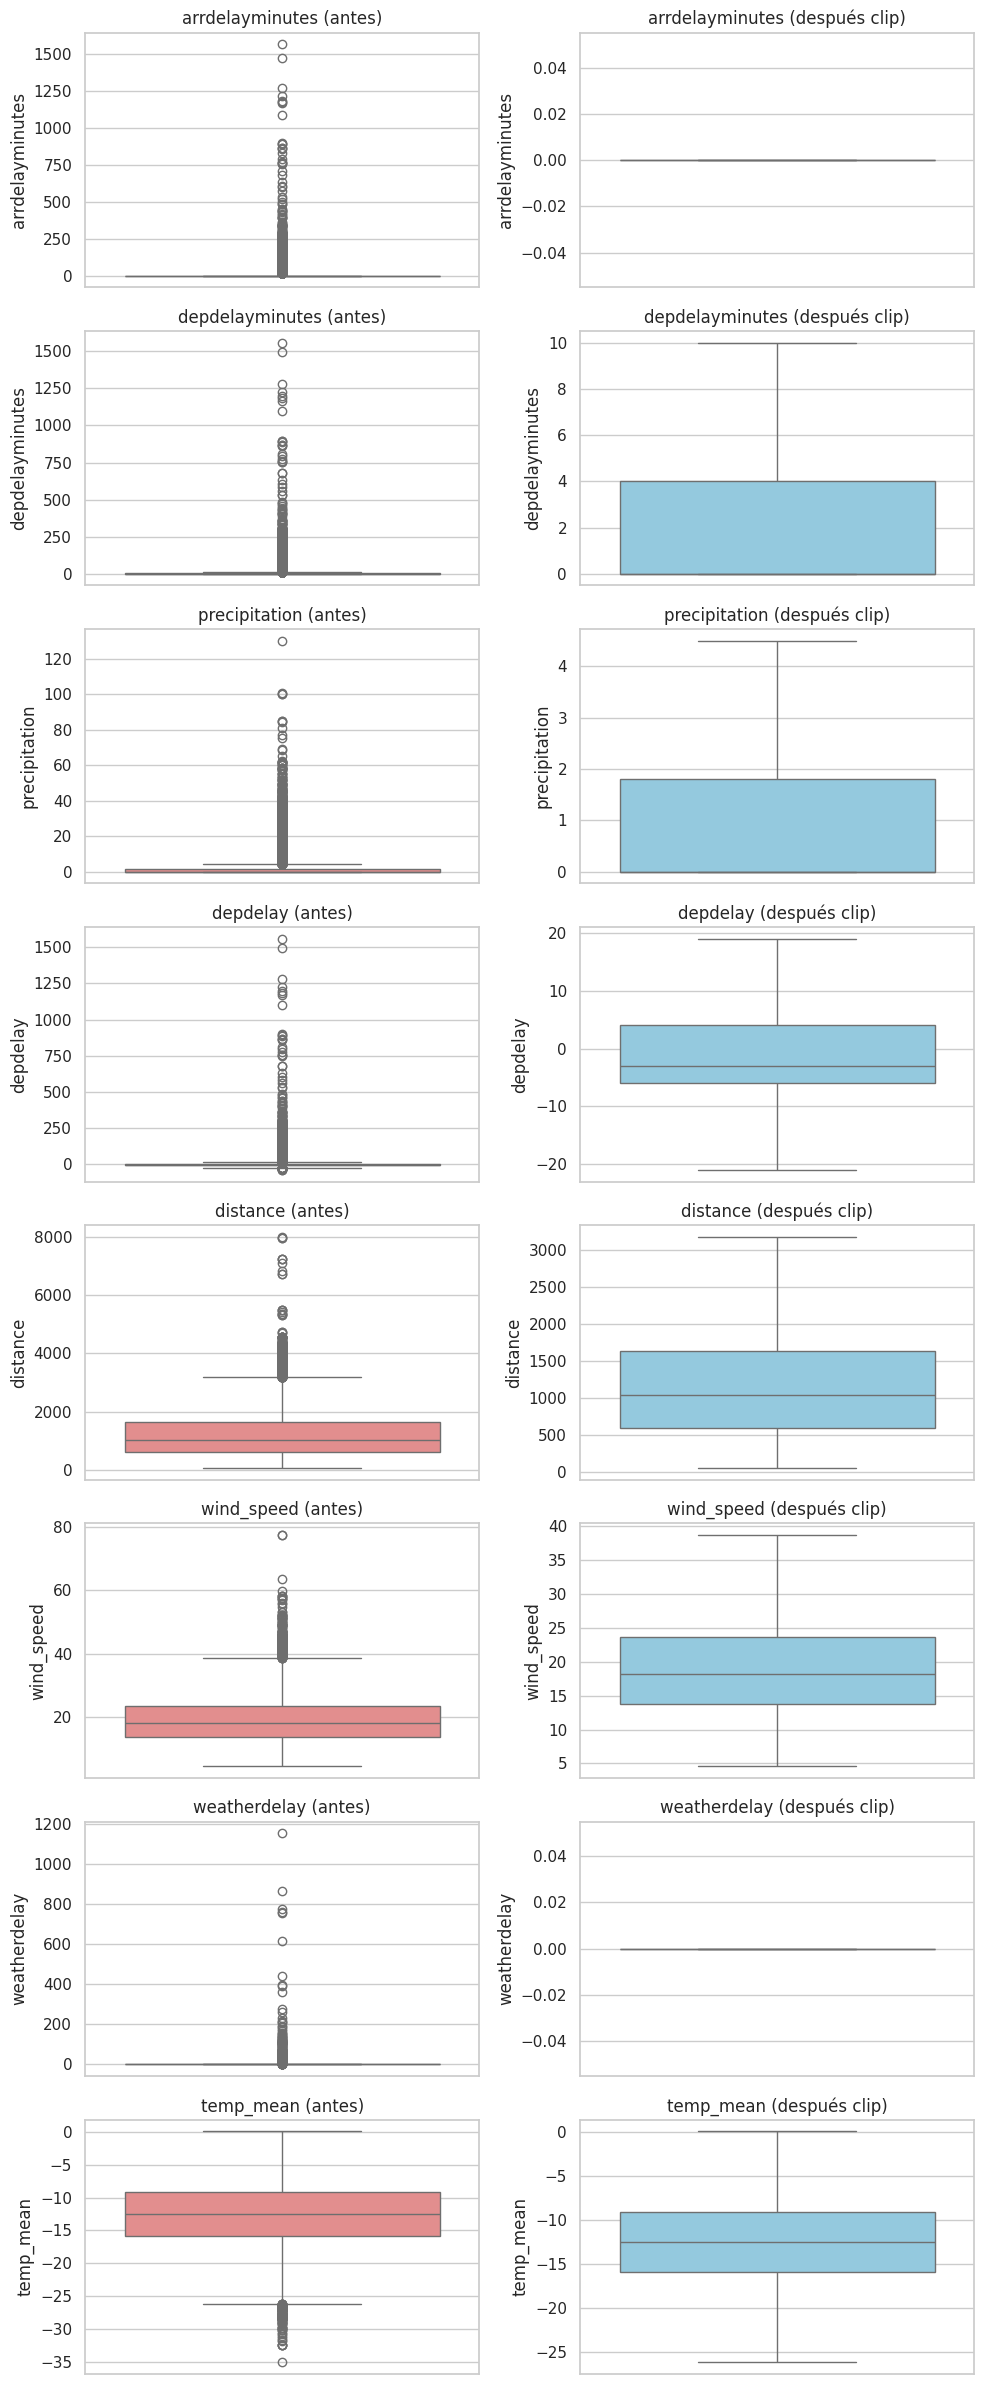

In [ ]:
key_outlier_columns = [col for col, _ in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:8]]

# 3) Guardar BEFORE (solo columnas a graficar)
df_before = df_numeric[key_outlier_columns].copy()  # copy() preserva el original [web:119]

# 4) Crear AFTER (capado) sin pisar el BEFORE
df_after = df_before.copy()
for col in key_outlier_columns:
    df_after[col] = df_after[col].clip(lower=lower_bound[col], upper=upper_bound[col])  # clip recorta a límites [web:84]

# 5) Graficar before vs after (2 columnas)
sns.set_style("whitegrid")
num_plots = len(key_outlier_columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(10, 3*num_plots), sharex=False)

for i, col in enumerate(key_outlier_columns):
    sns.boxplot(y=df_before[col], ax=axes[i, 0], color="lightcoral")
    axes[i, 0].set_title(f"{col} (antes)")

    sns.boxplot(y=df_after[col], ax=axes[i, 1], color="skyblue")
    axes[i, 1].set_title(f"{col} (después clip)")

plt.tight_layout()
plt.show()

---
> **Observaciones clave de los gráficos**
>
> A partir de los gráficos de caja y los histogramas, podemos observar lo siguiente:
>
> *   **Línea central en la caja**: representa la mediana (50º percentil) de los datos.
> *   **La caja**: delimita el Rango Intercuartílico (IQR), que es donde se encuentra el 50% central de los datos (entre el 25º y el 75º percentil).
> *   **Los 'bigotes'**: se extienden desde la caja hasta el último dato que no se considera atípico, generalmente 1.5 veces el IQR desde los cuartiles.
> *   **Puntos individuales fuera de los 'bigotes'**: estos son los *outliers* (valores atípicos), los cuales ya habíamos cuantificado. Su ubicación y densidad nos dan una idea de la magnitud de estos valores extremos.
>
> Para las columnas relacionadas con retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`):
>
> *   Se observa un marcado sesgo positivo, con la mayoría de los datos concentrados en valores bajos (cerca de cero o negativos) y una larga cola de *outliers* hacia arriba, indicando la presencia de retrasos muy significativos que se extienden a valores muy altos.
>
> Para la columna `distance`:
>
> *   Muestra una distribución con una concentración en distancias más cortas y algunos outliers hacia el extremo superior, lo que representa vuelos de muy larga distancia.
>
> Para las columnas relacionadas con retrasos (`precipitation`,  `weatherdelay`, `wind_speed`, `temp_mean`):
>
> - **precipitation**: la mayor parte de los valores está cerca de 0 y hay *outliers* altos; es típico en precipitaciones (muchos ceros y algunos eventos intensos).
> - **weatherdelay**: la distribución se concentra cerca de 0 con *outliers* muy altos; pocas observaciones con demoras meteorológicas grandes dominan la cola.
> - **wind_speed**: variabilidad moderada; existen *outliers* hacia arriba (vientos fuertes), pero el grueso está en un rango relativamente compacto.
> - **temp_mean**: distribución más compacta con *outliers* hacia temperaturas muy bajas (cola a la izquierda); los valores negativos son consistentes con una escala en °C.


In [ ]:
(df_before.ne(df_after)).sum().sort_values(ascending=False)

,0
arrdelayminutes,3736
depdelayminutes,3292
precipitation,2990
depdelay,2681
distance,929
wind_speed,276
weatherdelay,215
temp_mean,103


### Actualizar columnas en DataFrame principal

In [ ]:
cols_num = df_after.columns  # las columnas capadas

# (seguro) alinear por índice y columnas antes de actualizar
df.loc[df_after.index, cols_num] = df_after[cols_num]


In [ ]:
print("**Estadísticas antes **")
display(df_before[cols_check].describe().T)
print("\n** Estadísticas después **")
display(df_after[cols_check].describe().T)

**Estadísticas antes **


,count,mean,std,min,25%,50%,75%,max
arrdelayminutes,17449.0,13.734598,51.082424,0.000000,0.000000,0.000000,0.000000,1563.000000
depdelayminutes,17449.0,13.603989,51.324237,0.000000,0.000000,0.000000,4.000000,1559.000000
precipitation,17449.0,2.806098,6.913357,0.000000,0.000000,0.000000,1.800000,130.100000
depdelay,17449.0,10.033354,52.396858,-38.000000,-6.000000,-3.000000,4.000000,1559.000000
distance,17449.0,1262.546921,910.157719,49.889540,593.846460,1034.805620,1627.042740,8019.341220
wind_speed,17449.0,19.376681,7.407968,4.600000,13.700000,18.200000,23.700000,77.500000
weatherdelay,17449.0,0.973981,18.424419,0.000000,0.000000,0.000000,0.000000,1154.000000
temp_mean,17449.0,-12.550929,4.879321,-35.055556,-15.916667,-12.527778,-9.083333,0.083333



** Estadísticas después **


,count,mean,std,min,25%,50%,75%,max
arrdelayminutes,17449.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
depdelayminutes,17449.0,2.385065,4.034936,0.000000,0.000000,0.000000,4.000000,10.000000
precipitation,17449.0,1.149355,1.752682,0.000000,0.000000,0.000000,1.800000,4.500000
depdelay,17449.0,0.362542,9.623967,-21.000000,-6.000000,-3.000000,4.000000,19.000000
distance,17449.0,1225.942437,805.020273,49.889540,593.846460,1034.805620,1627.042740,3176.837160
wind_speed,17449.0,19.299341,7.143356,4.600000,13.700000,18.200000,23.700000,38.700000
weatherdelay,17449.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
temp_mean,17449.0,-12.539340,4.842709,-26.166667,-15.916667,-12.527778,-9.083333,0.083333



---

> **Aquí se presentan las estadísticas clave**:
>
> - **count (conteo)**: confirma la completitud de los datos (sin nulos en estas columnas).
>
> - **mean y median (50%)**: comparar estos valores ayuda a identificar el sesgo de la distribución. Si la media es significativamente mayor que la mediana, sugiere un sesgo positivo (cola larga hacia la derecha), como es el caso de los retrasos (`depdelay`, `depdelayminutes`, `arrdelayminutes`), indicando que la mayoría de los vuelos salen/llegan a tiempo o antes, pero hay algunos retrasos muy largos que tiran la media hacia arriba.
> - **std (desviación estándar)**: mide la dispersión de los datos. Un `std` alto en relación con la `mean` (como en `depdelay`) indica una gran variabilidad, lo que significa que los valores individuales se desvían mucho del promedio. Esto es crucial para entender la imprevisibilidad de los retrasos.
> - **min y max**: revelan el rango completo de los datos y la presencia de valores extremos. Por ejemplo, `min` negativos para `depdelay` y `depdelayminutes` indican vuelos que salieron antes de lo programado. `max` muy altos en los retrasos confirman la existencia de outliers o eventos de retraso muy significativos. El `max` de `distance` muestra vuelos de muy larga distancia.
> - **cuartiles (25%, 50%, 75%)**: proporcionan una visión de la distribución interna de los datos. Por ejemplo, para los retrasos, un 75% bajo (o incluso negativo) sugiere que la mayoría de los vuelos se ajustan a un horario puntual, y los retrasos significativos son menos frecuentes pero potentes. En `distance`, muestran cómo se distribuyen las distancias de vuelo típicas.



## **Distribuciones**

*   Balance del target (delayed)
*   Revisar si los datos siguen una curva normal o si están muy sesgados hacia un lado.
*   Buscar patrones usando gráficos (Matplotlib, Seaborn o Plotly).

In [ ]:
n_airlines = df['marketing_airline_network'].nunique()
n_origin_cities = df['origincityname'].nunique()

print("Líneas aéreas:", n_airlines)
print("Ciudades de origen:", n_origin_cities)

Líneas aéreas: 11
Ciudades de origen: 274


**Distribución de clases**

Un gráfico de barras que muestra el número de vuelos puntuales y retrasados en el dataset.

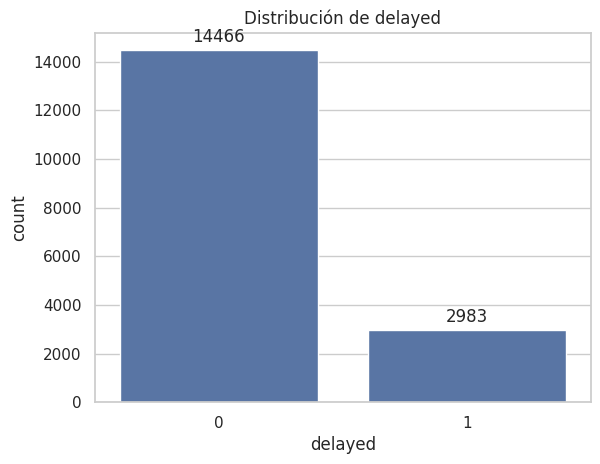


** Porcentaje de distribución de delayed **


,pct
delayed,
0,82.904464
1,17.095536


In [ ]:
# gráfico
ax = sns.countplot(x=df["delayed"])
ax.set_title("Distribución de delayed")
ax.set_xlabel("delayed")
ax.set_ylabel("count")

# labels con los conteos arriba de cada barra
# ax.containers[0] contiene las barras y bar_label las etiqueta automáticamente [web:244]
ax.bar_label(ax.containers[0], fmt="%d", padding=3)

plt.show()

# (opcional) si quieres que también se imprima como texto
print(f'\n** Porcentaje de distribución de delayed **')
display((df["delayed"].value_counts(normalize=True, dropna=False) * 100).rename("pct"))


Correlación (numéricas) para ver redundancias

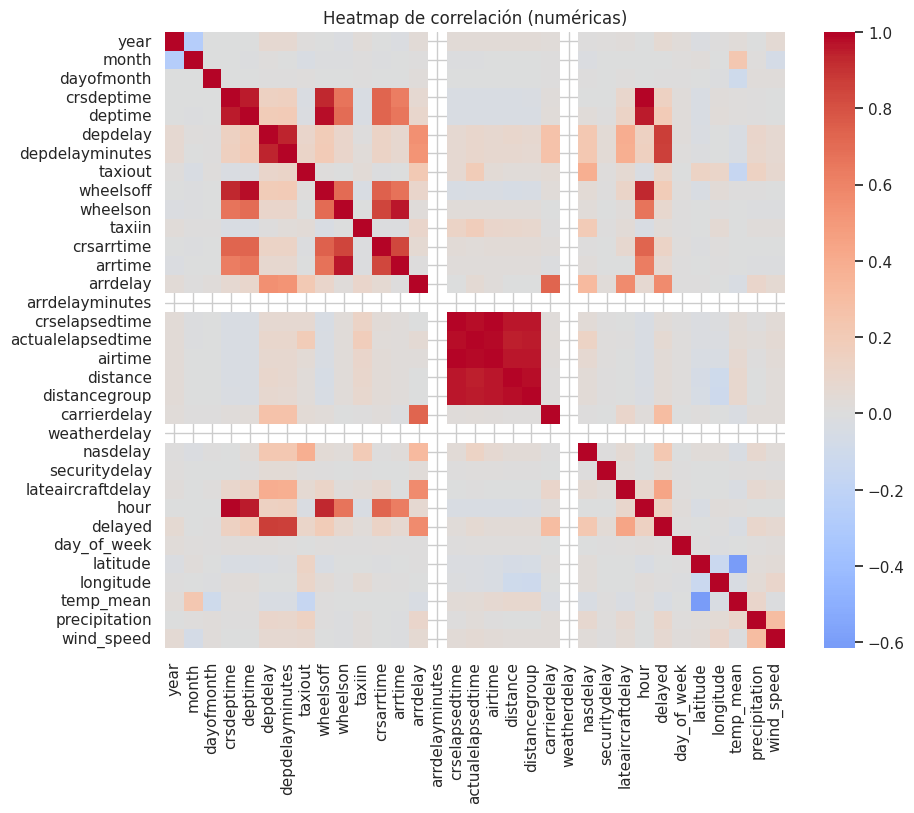

In [ ]:
num = df.select_dtypes(include=np.number)
corr = num.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Heatmap de correlación (numéricas)")
plt.show()


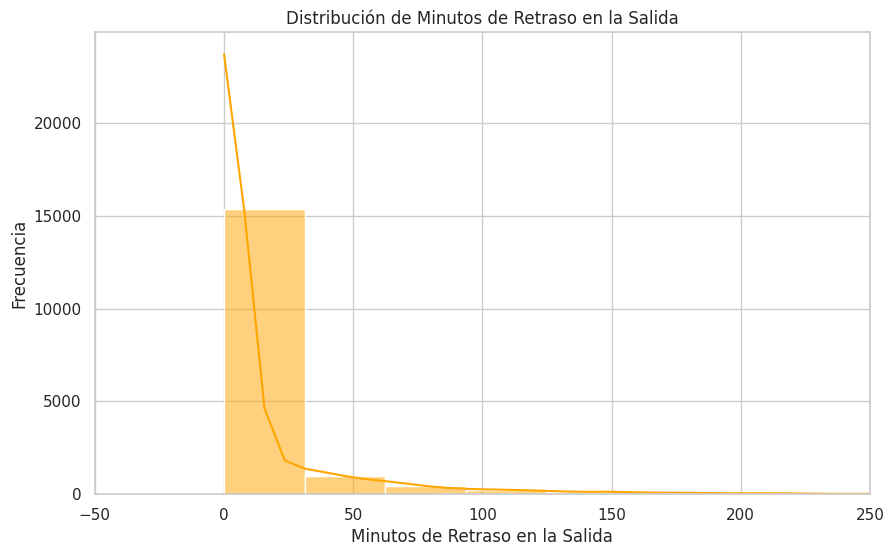

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['depdelayminutes'], bins=50, kde=True, color='orange')
plt.title('Distribución de Minutos de Retraso en la Salida')
plt.xlabel('Minutos de Retraso en la Salida')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

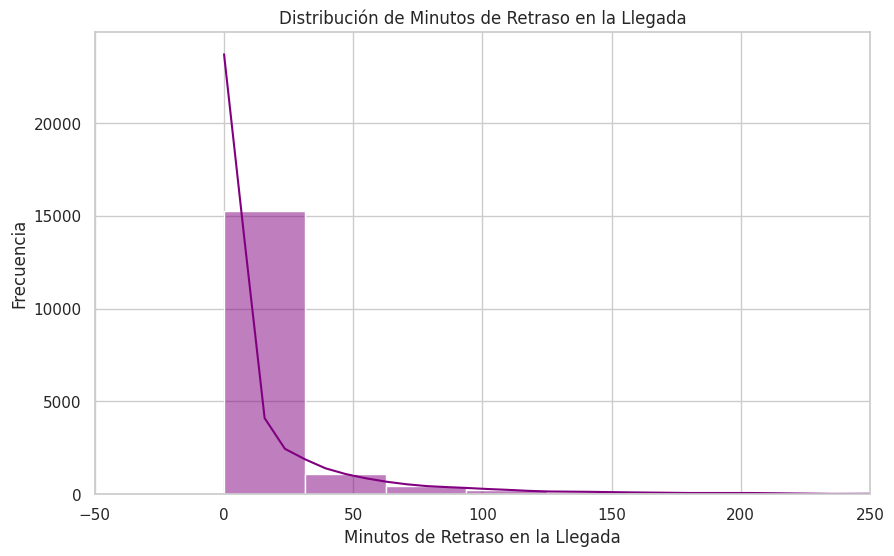

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['arrdelayminutes'], bins=50, kde=True, color='purple')
plt.title('Distribución de Minutos de Retraso en la Llegada')
plt.xlabel('Minutos de Retraso en la Llegada')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

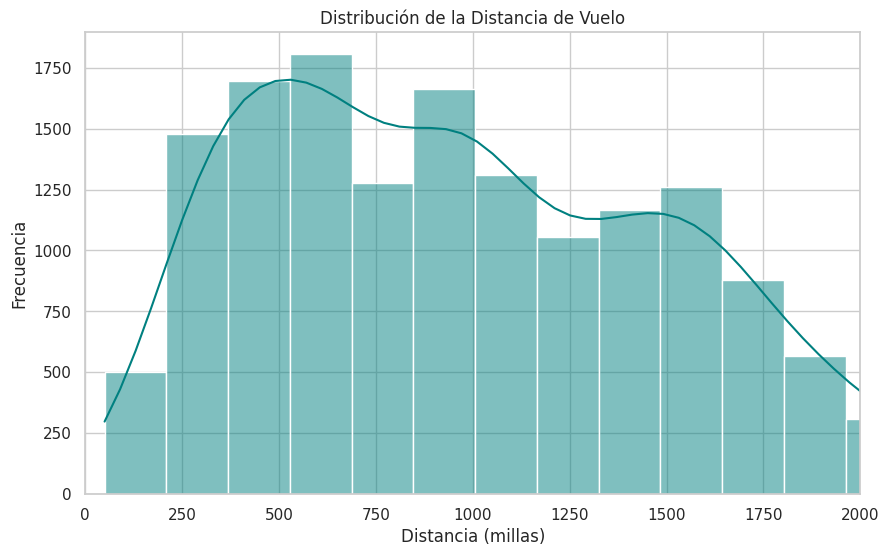

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['distance'], bins=50, kde=True, color='teal')
plt.title('Distribución de la Distancia de Vuelo')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')
plt.xlim(0, 2000) # Adjusted x-limit to show most common distances without extreme long-haul flights
plt.show()

### Resumen del análisis de distribución

---
> Basado en los histogramas generados para `depDelayminutes`, `arrdelayminutes`, y `distance`, las distribuciones:
>
> *   **`depdelayminutes`** y **`arrdelayminutes`**: ambas muestran distribuciones altamente sesgadas. Hay un pico muy fuerte en cero o cerca de cero, lo que indica que una gran mayoría de los vuelos salen y llegan a tiempo o incluso antes. Sin embargo, hay una larga cola que se extiende hacia la derecha, lo que muestra que, aunque son menos frecuentes, ocurren retrasos significativos. Estas distribuciones claramente no son normales y están fuertemente sesgadas positivamente.
>
> *   **`distance`**: la distribución de la distancia también está sesgada hacia la derecha, pero de manera menos dramática que las columnas de retraso. Muestra una mayor frecuencia para vuelos cortos, con la frecuencia disminuyendo gradualmente a medida que la distancia aumenta. Hay menos vuelos de larga distancia, lo que crea una cola hacia valores más altos. Esto es típico en conjuntos de datos de vuelos, donde muchas rutas de distancia corta a media son comunes, mientras que los vuelos internacionales muy largos son más raros.

## **Tipos de retrasos más comunes**

Vamos a crear un gráfico de barras para visualizar la frecuencia de cada causa de retraso. Esto nos mostrará qué tipos de retrasos son los más comunes en el conjunto de datos.

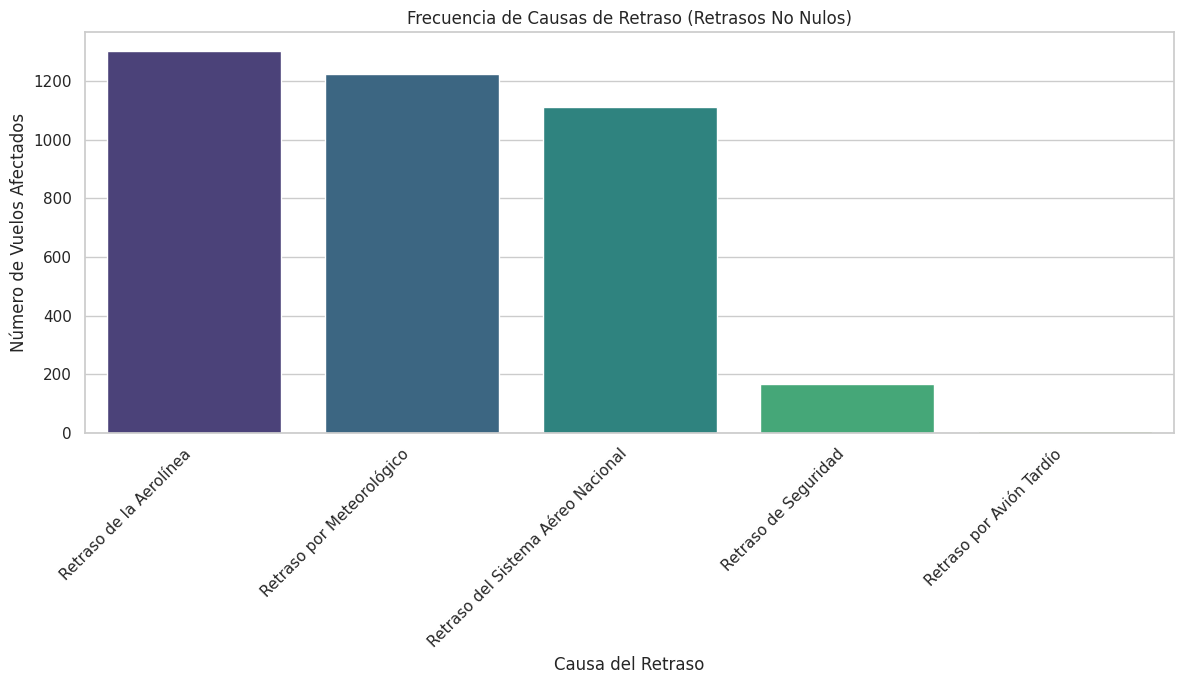

In [ ]:
delay_cause_columns = [
    'carrierdelay',
    'weatherdelay',
    'nasdelay',
    'securitydelay',
    'lateaircraftdelay'
]

delay_cause_columns_map = {
    0: 'Retraso de la Aerolínea',
    1: 'Retraso por Meteorológico',
    2: 'Retraso del Sistema Aéreo Nacional',
    3: 'Retraso de Seguridad',
    4: 'Retraso por Avión Tardío',
}


# Cuente el número de retrasos distintos de cero para cada caso
frequency_of_causes = {}
for col in delay_cause_columns:
    # Se considera que un vuelo tiene una causa de retraso si el retraso es > 15
    frequency_of_causes[col] = df_numeric[df_numeric[col] > 15].shape[0]

# Convertir a pandas para facilitar la representación gráfica
frequency_series = pd.Series(frequency_of_causes).sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    x=frequency_series.index,
    y=frequency_series.values,
    hue=frequency_series.index,
    palette='viridis',
    legend=False
)
plt.title('Frecuencia de Causas de Retraso (Retrasos No Nulos)')
plt.xlabel('Causa del Retraso')
plt.ylabel('Número de Vuelos Afectados')
plt.xticks(
    ticks=range(5),
    labels=[delay_cause_columns_map[i] for i in range(5)],
    rotation=45, ha='right'
)
plt.tight_layout()
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> El gráfico de barras anterior muestra el número de vuelos afectados por cada causa específica de retraso, considerando solo los minutos de retraso no nulos. Esta visualización ayuda a identificar los tipos de retrasos más frecuentes en nuestro conjunto de datos. Podemos observar que `carrierdelay`, `lateaircraftdelay` y `nasdelay` son las causas más frecuentes, afectando a miles de vuelos, mientras que `weatherdelay` y especialmente `securitydelay` son menos frecuentes.

## **Probabilidad de retraso de vuelo por hora de salida programada**

Delay rate: 0.1710
Valores únicos en 'delayed': [0 1]
hour
0     0.142857
1     0.111111
2     0.000000
3     1.000000
4     0.000000
5     0.074176
6     0.072926
7     0.099145
8     0.109688
9     0.119595
10    0.132143
11    0.147166
12    0.169125
13    0.186581
14    0.164223
15    0.215855
16    0.200824
17    0.231323
18    0.225655
19    0.262564
20    0.247205
21    0.236364
22    0.225806
23    0.247619
Name: delayed, dtype: float64


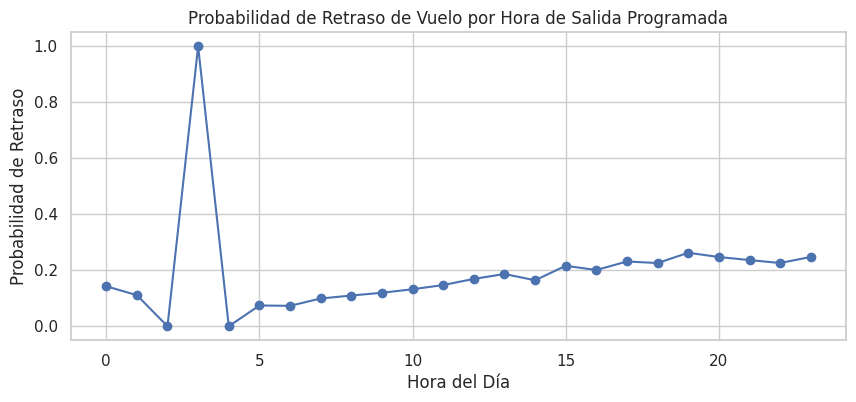

In [ ]:
# Probabilidad de delay en la muestra
delay_rate = df_numeric["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df_numeric["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probabilidad de Retraso de Vuelo por Hora de Salida Programada")
plt.xlabel("Hora del Día")
plt.ylabel("Probabilidad de Retraso")
plt.grid(True)
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Baja probabilidad de retraso en la *temprana mañana***: la probabilidad de retraso es generalmente baja durante las primeras horas de la mañana (por ejemplo, de 1 AM a 6 AM). Los vuelos programados para despegar en este intervalo tienden a tener menos posibilidades de ser retrasados.
>
> *   **Aumento de la probabilidad a lo largo del día**: a medida que avanza el día, la probabilidad de que un vuelo sea retrasado aumenta de manera constante. Esta tendencia se vuelve más notable desde finales de la mañana hasta la tarde y el principio de la noche.
>
> *   **Pico de probabilidad de retraso en la tarde/noche**: las mayores probabilidades de retraso se observan en la tarde y a inicios de la noche (aproximadamente entre las 4 PM y las 9 PM). Esto se debe a una combinación de factores: retrasos acumulativos de horas anteriores, mayor tráfico aéreo y posibles cambios climáticos.
>
> *   **Ligera disminución a última hora de la noche**: hacia las últimas horas de la noche (por ejemplo, a partir de las 10 PM), la probabilidad de retraso tiende a disminuir nuevamente, probablemente debido a la reducción del tráfico aéreo.

## **Probabilidad de retraso según la distancia de vuelo**

In [ ]:
# Crear bins de distancia (5 quintiles)
df_numeric["distance_bin"] = pd.qcut(df_numeric["distance"], q=5)

distance_bin
(49.889, 513.379]       0.152242
(513.379, 870.653]      0.154994
(870.653, 1266.551]     0.167237
(1266.551, 1775.102]    0.184407
(1775.102, 8019.341]    0.196039
Name: delayed, dtype: float64


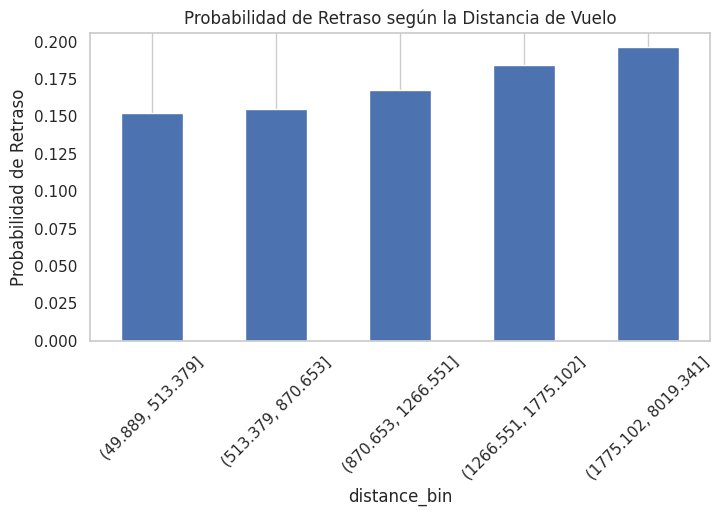

In [ ]:
# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df_numeric.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Probabilidad de Retraso según la Distancia de Vuelo")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Probabilidad variada según las distancias**: la probabilidad de retraso no es constante en todas las distancias de vuelo. Varía dependiendo de la longitud del vuelo. A mayor distancia (por intervalos), mayor probabilidad de retraso.
>
> *   **Vuelos cortos tienen menor probabilidad de retraso**: los vuelos más cortos (rango de distancia (`30.999, 319.0`]) muestran la menor probabilidad de retraso (alrededor del 15%). Esto puede deberse a que las rutas más cortas son menos propensas a acumular retrasos o a enfrentar condiciones climáticas variadas.
>
> *   **Vuelos intermedios y largos**: los vuelos en rangos de distancia intermedios y largos ((`319.0, 541.0`], (`541.0, 787.0`], (`787.0, 1103.0`], (`1103.0, 4983.0`]) tienden a tener probabilidades de retraso ligeramente más altas y más consistentes, que oscilan aproximadamente entre el 18% y el 19%.
>
> *   **Sin relación lineal directa**: no hay una relación lineal clara y fuerte donde la probabilidad de retraso aumente o disminuya continuamente con la distancia. En cambio, parece fluctuar dentro de un cierto rango para vuelos de media a larga distancia después de una probabilidad inicial más baja para vuelos muy cortos.

## **Probabilidad de retraso por día de la semana**

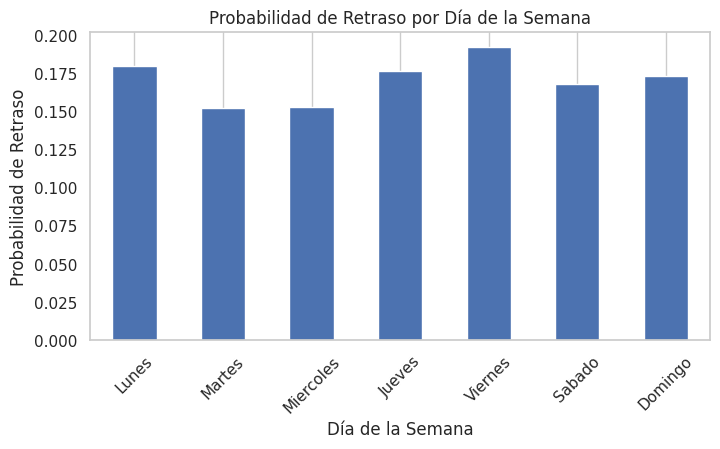

In [ ]:
# Map day numbers to day names
days_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miercoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sabado',
    6: 'Domingo'
}

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df_numeric.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.xticks(
    ticks=range(7),
    labels=[days_map[i] for i in range(7)],
    rotation=45
)
plt.title("Probabilidad de Retraso por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Probabilidad de Retraso")
plt.grid(axis="y")
plt.show()

---
> **Observaciones clave del gráfico**
>*   **Mayor probabilidad de retraso los Viernes y Lunes**: el gráfico probablemente muestra que los vuelos los lunes tienen una probabilidad relativamente más alta de ser retrasados. Esto podría deberse a una mayor demanda de viajes al comienzo de la semana laboral, a viajes de negocios o a retrasos acumulados del fin de semana.
>
>*   **Probabilidades más bajas en mitad de semana**: típicamente, los días de mitad de semana como Martes, Miércoles y Jueves pueden mostrar probabilidades de retraso ligeramente más bajas en comparación con el inicio o el final de la semana. Las operaciones pueden ser más fluidas con menos pasajeros y menos congestión.
>
>*   **Variabilidad en los fines de semana**: Sábados y Domingos pueden tener patrones variados. A veces, los sábados muestran probabilidades más bajas debido a un tráfico de negocios más ligero, mientras que los Domingos pueden aumentar debido a los viajes de regreso.



## **Top 10 Aerolíneas por probabilidad de retraso**

marketing_airline_network
VX    0.400000
G4    0.285714
B6    0.271756
F9    0.241379
NK    0.227898
HA    0.222222
WN    0.210079
UA    0.165356
AA    0.152684
DL    0.138420
Name: delayed, dtype: float64


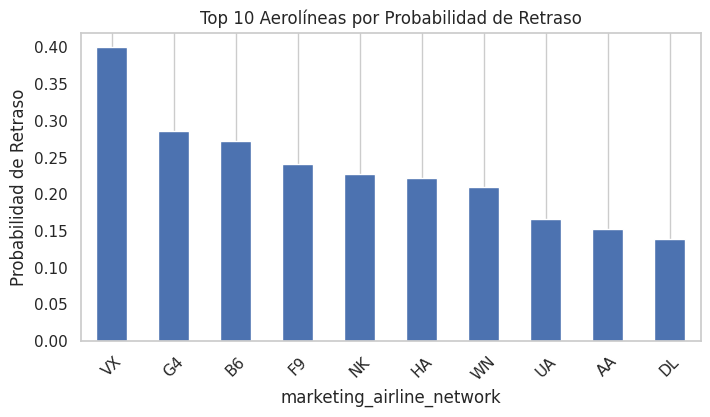

In [ ]:
# Crear una columna 'Marketing_Airline_Network' en df_numeric
df_numeric['marketing_airline_network'] = df['marketing_airline_network']

# Probabilidad de retraso por aerolínea (top 10)
alert_data = (
    df_numeric.groupby("marketing_airline_network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(alert_data)

# Graficar
plt.figure(figsize=(8,4))
alert_data.plot(kind="bar")
plt.title("Top 10 Aerolíneas por Probabilidad de Retraso")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

## Comprobación de variable objetivo binaria

In [ ]:
df_numeric["delayed"].value_counts(normalize=True)

hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"La probabilidad de retraso de los vuelos en promedio\na lo largo de las diferentes horas del día: {hour_std:.2%}")

La probabilidad de retraso de los vuelos en promedio
a lo largo de las diferentes horas del día: 18.75%


---
>
> Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
> si la variación es alta, significa que la hora del vuelo influye de forma real
> en los retrasos, y el ratio entre datasets, nos permite comparar cuál captura
> mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.
>
> Al medir la variación de la probabilidad de retraso según la hora, verificamos
> que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
> qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
> computacional.



# **6. 🎯 Definición del objetivo (target) y selección de columnas para el entrenamiento)**

---

La variable objetivo (*target*) del modelo es `delayed`, que indica si el vuelo presentó retraso.

Las columnas seleccionadas para el entrenamiento son:

- `marketing_airline_network`
- `airport_code`
- `destcityname`
- `distance`
- `year`
- `month`
- `dayofmonth`
- `day_of_week`
- `hour`
- `temp_mean`
- `precipitation`
- `wind_speed`


In [ ]:
# Definimos las columnas mínimas necesarias
required_cols = [
    "delayed",
    'marketing_airline_network', 'airport_code', 'destcityname', 'distance',
    'year', 'month', 'dayofmonth', 'day_of_week', 'hour',
    'temp_mean', #'temp', #
    'precipitation', 'wind_speed'
]

required_cols_ok = [c for c in required_cols if c in df.columns]
df = df[required_cols_ok].copy()


# Filtramos:
# - horas válidas (0–23)
# - distancias positivas
df = df[df["hour"].between(0, 23)]
df = df[df["distance"] > 0]


In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 1


In [ ]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)
print("Registros después de eliminar duplicados:", len(df))

Registros después de eliminar duplicados: 17448


In [ ]:
# Exportar a CSV
df.to_csv("flight_data_processed.csv", index=False)

# **7. 🤖 Modelado**
---


Dividir el DataFrame en `X` (características de entrada) e `y` (variable objetivo a predecir)

In [ ]:
# FEATURES: variables predictoras
# TARGET: variable objetivo (retraso sí/no)

FEATURES = [
    'marketing_airline_network', 'airport_code', 'destcityname', 'distance',
    'year', 'month', 'dayofmonth', 'day_of_week', 'hour',
    'temp_mean', #'temp', #
    'precipitation', 'wind_speed'
]
TARGET = "delayed"

X = df[FEATURES].copy()
y = df[TARGET].astype(int)

### Definición de columnas numéricas y categóricas

Se crea un `ColumnTransformer` que aplicará diferentes transformaciones a diferentes tipos de columnas: las columnas numéricas se pasan "tal cual" (`passthrough`), mientras que las columnas categóricas se transforman usando `OneHotEncoder`.

Esto convierte las categorías de texto (como los nombres de aerolíneas) en un formato numérico binario que los modelos pueden entender. `handle_unknown='ignore'` previene errores si aparecen nuevas categorías no vistas durante el entrenamiento.

In [ ]:
# Necesario para aplicar transformaciones distintas, separamos numericas de categóricas.
numeric_features = ["year","month","dayofmonth","day_of_week","hour","distance","temp_mean","precipitation","wind_speed"]
categorical_features = ["marketing_airline_network","airport_code","destcityname"]

# Transformadores (imputan + escalan / imputan + onehot)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# split de numéricas: log1p vs normales
log1p_features = [c for c in ["precipitation"] if c in numeric_features]
other_numeric_features = [c for c in numeric_features if c not in log1p_features]

# definir transformers/pipelines y el ColumnTransformer
log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe = OneHotEncoder(
    handle_unknown="ignore",
    # min_frequency=0.01,
    sparse_output=True
)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", ohe)
])

# - Variables numéricas: pasan tal cual
# - Variables categóricas: One-Hot Encoding

# Preprocessor correcto (NO passthrough)
preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", log_numeric_transformer, log1p_features),
        ("num", numeric_transformer, other_numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


## **⚖️ Modelo de Regresión Logística**


### Creación del pipeline del modelo

Se construye un `Pipeline` que encadena dos pasos: el preprocesamiento definido anteriormente y un modelo de `LogisticRegression`. Se configura `max_iter=2000` para asegurar la convergencia y `class_weight='balanced'` para manejar el desbalance de clases (ya que los retrasos son menos frecuentes que los vuelos puntuales).

In [ ]:
# Regresión logística:
# 1) Preprocesado
# 2) Modelo de clasificación

model = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("sampler", SMOTE(random_state=42)),  # o RandomOverSampler(...)
    ("classifier", LogisticRegression(
        class_weight=None,     # normalmente se desactiva cuando ya sobremuestreas
        max_iter=2000,
        solver="saga"
    ))
])

In [ ]:
print(model.named_steps['preprocess'])

ColumnTransformer(transformers=[('num_log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log1p',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['precipitation']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['year', 'month', 'dayofmonth', 'day_of_week',
                                  'hour', 'distance', 'temp_mean',
       

### Dividir datos en conjuntos de entrenamiento y test

Se utiliza `train_test_split` para dividir los datos `X` e `y` en conjuntos de entrenamiento (80%) y prueba (20%). El parámetro `stratify=y` es crucial para asegurar que la proporción de vuelos retrasados y puntuales se mantenga similar en ambos conjuntos, lo cual es importante en datasets desbalanceados.

In [ ]:
# Creamos un pseudo-id de vuelo
groups = (
    df["year"].astype(str) + "_" +
    df["month"].astype(str) + "_" +
    df["dayofmonth"].astype(str) + "_" +
    df["hour"].astype(str) + "_" +
    df["marketing_airline_network"].astype(str) + "_" +
    df["airport_code"].astype(str) + "_" +
    df["destcityname"].astype(str)
)

X = df[FEATURES]
y = df[TARGET]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx]
X_test  = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Verificación
train_groups = set(groups.iloc[train_idx])
test_groups  = set(groups.iloc[test_idx])
print("Vuelos repetidos entre train y test:", len(train_groups & test_groups))




Train size: (13958, 12)
Test size: (3490, 12)
Vuelos repetidos entre train y test: 0


### Validar pre-proceso para nulls

In [ ]:
Xt = model.named_steps["preprocess"].fit_transform(X_train, y_train)

if sparse.issparse(Xt):
    print("NaN en Xt.data:", np.isnan(Xt.data).sum())
else:
    print("NaN en Xt:", np.isnan(Xt).sum())

NaN en Xt.data: 0


In [ ]:
print(model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precipitation']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                    

### Entrenar el modelo

El pipeline (`model`) es entrenado con los datos de entrenamiento (`X_train`, y_train). Durante este paso, el preprocesador transforma los datos y luego la **Regresión Logística** aprende los patrones para predecir retrasos.

Se realizan dos tipos de predicciones sobre el conjunto de prueba (`X_test`):

*   `y_pred`: predicciones binarias (0 = Puntual, 1 = Retrasado).
*   `y_proba`: probabilidades de que un vuelo se retrase (la probabilidad de la clase 1).

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['precipitation']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   Standar...
                                                   'hour', 'distance',
                                                   'temp_mean', 'wind_speed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marketing_airline_network',
                                                   'airport_code',
                                                   'destcityname'])])),
                ('sampler', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=2000, solver='saga'))])

### **Evaluar el modelo**

In [ ]:
# evaluamos regresión
# y_pred: clase final
# y_proba: probabilidad de retraso

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("LOGISTIC REGRESSION\n")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      2886
           1       0.25      0.58      0.35       604

    accuracy                           0.63      3490
   macro avg       0.56      0.61      0.54      3490
weighted avg       0.77      0.63      0.67      3490

ROC AUC: 0.6457251953940696


### **Reevaluar el modelo**


Se imprimen dos métricas clave para evaluar el rendimiento del modelo:
*   `classification_report`: ofrece un resumen detallado de la precisión (precision), la exhaustividad (recall) y la puntuación F1 para ambas clases.
*   `roc_auc_score`: mide la capacidad del modelo para distinguir entre vuelos puntuales y retrasados.

In [ ]:
sampler = model.named_steps["sampler"]

X_res_tmp, y_res_tmp = sampler.fit_resample(
    model.named_steps["preprocess"].transform(X_train),
    y_train
)
print("Distribución tras sampler en pipeline:", Counter(y_res_tmp))

Distribución tras sampler en pipeline: Counter({0: 11579, 1: 11579})


In [ ]:
# evaluamos regresión
# y_pred: clase final
# y_proba: probabilidad de retraso

# Reajustar el modelo para asegurar que el pipeline (incluido el sampler) se aplique
# asumiendo que `model` es un ImbPipeline que incluye el paso de sampler
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("LOGISTIC REGRESSION (after resampling)")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

LOGISTIC REGRESSION (after resampling)
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      2886
           1       0.25      0.58      0.35       604

    accuracy                           0.63      3490
   macro avg       0.56      0.61      0.54      3490
weighted avg       0.77      0.63      0.67      3490

ROC AUC: 0.6457251953940696


### **Guardar modelo**


El modelo entrenado se guarda en un archivo `flight_delay_model.pkl` usando `joblib`. Esto permite que el modelo pueda ser cargado y utilizado posteriormente sin necesidad de reentrenarlo.

In [ ]:
# Se guarda el pipeline completo (preprocesado + modelo)

joblib.dump(model, "regresion_model.pkl")
print("Exportando modelo regresion_model")

Exportando modelo regresion_model


## **🌲🌲🌲 Modelo Random Forest**


Esta sección introduce un segundo modelo, un **RandomForestClassifier**, que es un modelo de conjunto basado en árboles de decisión, generalmente más potente que la **Regresión Logística**.

### Creación del pipeline del modelo

**Configurar preprocesor**

In [ ]:
numeric_features = ["year","month","dayofmonth","day_of_week","hour","distance","temp_mean","precipitation","wind_speed"]
categorical_features = ["marketing_airline_network","airport_code","destcityname"]

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

ohe = OneHotEncoder(
    handle_unknown="infrequent_if_exist",
    min_frequency=0.02,      # o un entero, ej: 50
    sparse_output=True
)

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", ohe)
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer_rf, categorical_features),
    ],
    remainder="drop"
)

**Configurar el pipeline para Random Forest**

Se crea un nuevo pipeline (`rf_model`) que utiliza el mismo preprocessor que antes, pero en este caso, el clasificador es un `RandomForestClassifier`. Se configuran algunos hiperparámetros como `n_estimators` (número de árboles, 100 es un valor común), `max_depth` (profundidad máxima de cada árbol), `random_state` para reproducibilidad, y `class_weight='balanced'` para manejar el desbalance de clases.

In [ ]:
# Random Forest
# Misma entrada y preprocesado
# Solo cambia el modelo final

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("classifier", RandomForestClassifier(
        n_estimators=300,              # más estable que 100 (baseline)
        max_depth=None,               # deja crecer; luego ajustas con max_depth=10,
        min_samples_leaf=2,           # reduce overfitting (ajustable)
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
        #class_weight="balanced_subsample"  # buena opción en RF para desbalance
    ))
])


rf_model_resampled = ImbPipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("sampler", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight="balanced"))
])



### **Entrenar el modelo**

El `rf_model_resampled` se entrena con los mismos datos de entrenamiento (`X_train`, y_train).

In [ ]:
rf_model_resampled.fit(X_train, y_train)  # Automático: preprocess -> resample -> fit

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['year', 'month',
                                                   'dayofmonth', 'day_of_week',
                                                   'hour', 'distance',
                                                   'temp_mean', 'precipitation',
                                                   'wind_speed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.02))]),
                                                  ['marketing_airline_network',
                                                   'airport_code',
                                                   'destcityname'])])),
                ('sampler', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

### **Evaluar el modelo**

Se obtienen las predicciones binarias (`y_pred_rf`) y las probabilidades de retraso (`y_proba_rf`) para el conjunto de prueba.

Se imprimen las métricas de evaluación (`classification_report` y `roc_auc_score`) específicas para el modelo **Random Forest**. Esto permite comparar su rendimiento con el de la **Regresión Logístic**a.

In [ ]:
#y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model_resampled.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba_rf)  # PR curve

f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1[:-1])          # thr es más corto que prec/rec
best_thr = thr[best_idx]

print("Mejor umbral (max F1):", best_thr)

y_pred_rf = (y_proba_rf >= best_thr).astype(int)

print("RANDOM FOREST\n")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR AUC (AP):", average_precision_score(y_test, y_proba_rf))

Mejor umbral (max F1): 0.24633877004344906
RANDOM FOREST

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      2886
           1       0.32      0.59      0.41       604

    accuracy                           0.71      3490
   macro avg       0.61      0.66      0.61      3490
weighted avg       0.80      0.71      0.74      3490

ROC AUC: 0.7059284832463641
PR AUC (AP): 0.3319495287459556


### Buscar parametros optimos y reentrenar

Usar RandomizedSearchCV para RandomForest, lo qu suele mejorar bastante al buscar max_depth, min_samples_leaf y max_features (y subir n_estimators). AVISO: estas celdas demoran alrededor de **30 min** en ejecutarse.

In [ ]:
# Split inicial: train+val vs test (20% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split interno: train vs val (por ejemplo 20% de trainval -> 16% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=42,
    stratify=y_trainval
)

In [ ]:
rf_model_balanced = ImbPipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("sampler", SMOTE(random_state=42)),  # <-- AQUÍ agregas el balanceo
    ("classifier", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

param_dist = {
    "classifier__n_estimators": randint(200, 600),
    "classifier__max_depth": [None, 8, 12, 16, 20],
    "classifier__min_samples_leaf": randint(1, 10),
    "classifier__min_samples_split": randint(2, 20),
    "classifier__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(
    #estimator=rf_model,
    estimator=rf_model_balanced,  # <-- Cambio clave
    param_distributions=param_dist,
    n_iter=15,          # antes 40
    cv=3,               # antes 5
    #scoring="average_precision", # PR AUC (AP) suele ser mejor para desbalance
    scoring=make_scorer(fbeta_score, beta=2, average='binary'),
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

search.fit(X_train, y_train)
print("Mejores params:", search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Mejores params: {'classifier__max_depth': 8, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 550}


### Evaluar el modelo reentrenado

In [ ]:
best_rf = search.best_estimator_
min_prec_val = 0.42  # más conservador que 0.41

# --- VALIDACIÓN: elegir umbral ---
y_proba_val = best_rf.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)
prec_t, rec_t = prec[:-1], rec[:-1]

mask = prec_t >= min_prec_val

if not np.any(mask):
    raise ValueError(f"No existe umbral en VAL con precision >= {min_prec_val:.2f}")

# candidatos
cand_thr = thr[mask]
cand_prec = prec_t[mask]
cand_rec  = rec_t[mask]

# ordenar por (recall desc, precision desc) y tomar el primero
order = np.lexsort((-cand_prec, -cand_rec))
best_thr = cand_thr[order[0]]
best_prec = cand_prec[order[0]]
best_rec = cand_rec[order[0]]

print(f"Umbral elegido en VAL (precision>={min_prec_val:.2f}, recall máximo): {best_thr:.6f}")
print(f"VAL precision={best_prec:.3f} | recall={best_rec:.3f}")

# --- TEST: evaluar una sola vez ---
y_proba_test = best_rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_thr).astype(int)

print("\nTEST (evaluación final)\n")
print(classification_report(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
print("PR AUC (AP):", average_precision_score(y_test, y_proba_test))


Umbral elegido en VAL (precision>=0.42, recall máximo): 0.607260
VAL precision=0.423 | recall=0.023

TEST (evaluación final)

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      2893
           1       0.42      0.02      0.04       597

    accuracy                           0.83      3490
   macro avg       0.63      0.51      0.47      3490
weighted avg       0.76      0.83      0.76      3490

ROC AUC: 0.64211627326632
PR AUC (AP): 0.25972755547608706


### **Guardar modelo**

In [ ]:
joblib.dump(best_rf, 'best_rf_balanced.pkl')
print("Exportado modelo rf_model_balanced")

Exportado modelo rf_model_balanced


## **🌳 Modelo Decision Tree**

### Creación del pipeline del modelo

In [ ]:
# Pipeline con balanceo para DecisionTree
dt_model_balanced = ImbPipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("sampler", SMOTE(random_state=42)),  # Balanceo aquí
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Hiperparámetros específicos para DecisionTree
param_dist = {
    "classifier__max_depth": [3, 5, 8, 12, 15, None],
    "classifier__min_samples_leaf": randint(1, 20),
    "classifier__min_samples_split": randint(2, 30),
    "classifier__max_features": ["sqrt", "log2", None, 0.5, 0.8],
    "classifier__class_weight": ["balanced", None]  # Extra protección
}

search = RandomizedSearchCV(
    estimator=dt_model_balanced,
    param_distributions=param_dist,
    n_iter=20,  # Más iteraciones para DT (menos estable)
    cv=5,       # CV más robusto para DT
    scoring="average_precision",
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

### **Entrenar el modelo**

In [ ]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['year',
                                                                                'month',
                                                                                'dayofmonth',
                                                                                'day_of_week',
                                                                                'hour',
                                                                                'distance',
                                                                                'temp_mean',
                                                                                'precipitation',
                                                                                'wind_speed']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='c...
                                        'classifier__max_depth': [3, 5, 8, 12,
                                                                  15, None],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     None, 0.5,
                                                                     0.8],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d0d74782810>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d0d747824e0>},
                   random_state=42, scoring='average_precision', verbose=2)

### **Evaluar el modelo**

In [ ]:
print("Mejores params DT:", search.best_params_)
print("Mejor score AP:", search.best_score_)

Mejores params DT: {'classifier__class_weight': None, 'classifier__max_depth': 8, 'classifier__max_features': 0.8, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 25}
Mejor score AP: 0.2511832073304655


In [ ]:
# Después de search.fit(X_train, y_train)
best_dt = search.best_estimator_

min_prec_val = 0.42  # Óptimo elegido

# VALIDACIÓN: elegir umbral
y_proba_val = best_dt.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba_val)
prec_t, rec_t = prec[:-1], rec[:-1]

mask = prec_t >= min_prec_val
if not np.any(mask):
    raise ValueError(f"No existe umbral en VAL con precision >= {min_prec_val:.2f}")

# Candidatos ordenados (recall desc, precision desc)
cand_thr = thr[mask]
cand_prec = prec_t[mask]
cand_rec = rec_t[mask]
order = np.lexsort((-cand_prec, -cand_rec))
best_thr = cand_thr[order[0]]
best_prec = cand_prec[order[0]]
best_rec = cand_rec[order[0]]

print(f"Umbral elegido en VAL (precision>={min_prec_val:.2f}): {best_thr:.6f}")
print(f"VAL precision={best_prec:.3f} | recall={best_rec:.3f}")

# TEST: evaluar una sola vez
y_proba_test = best_dt.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_thr).astype(int)

print("\nTEST (evaluación final)\n")
print(classification_report(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
print("PR AUC (AP):", average_precision_score(y_test, y_proba_test))


Umbral elegido en VAL (precision>=0.42): 0.714286
VAL precision=0.444 | recall=0.017

TEST (evaluación final)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2893
           1       0.44      0.01      0.03       597

    accuracy                           0.83      3490
   macro avg       0.64      0.50      0.47      3490
weighted avg       0.76      0.83      0.76      3490

ROC AUC: 0.6170172790441435
PR AUC (AP): 0.2400037467093806


### **Guardar modelo**

In [ ]:
joblib.dump(best_dt, 'dt_model_balanced.pkl')
print("Exportado modelo dt_model_balanced")

Exportado modelo dt_model_balanced


# 🏆 **Comparación y selección del mejor modelo**

Generamos la curva ROC para todos los modelos y las comparamos.

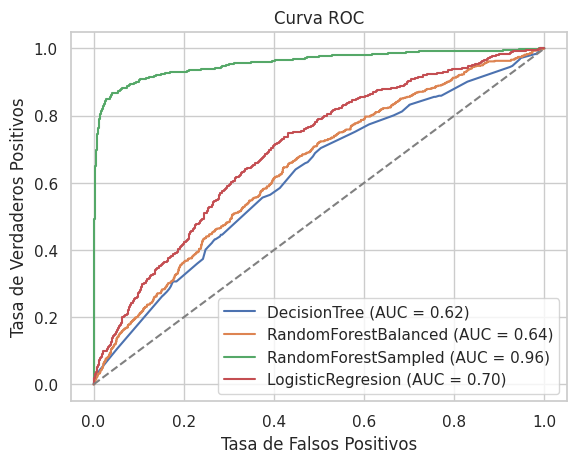

In [ ]:
y_proba_forest_sampled = rf_model_resampled.predict_proba(X_test)[:, 1]
y_proba_forest_balanced = best_rf.predict_proba(X_test)[:, 1]
y_proba_arbol_balanced = best_dt.predict_proba(X_test)[:, 1]
y_proba_logistic = model.predict_proba(X_test)[:, 1]

fpr_arbol_bal, tpr_arbol_bal, _ = roc_curve(y_test, y_proba_arbol_balanced)
roc_auc_arbol_bal = roc_auc_score(y_test, y_proba_arbol_balanced)

fpr_forest_samp, tpr_forest_samp, _forest_samp = roc_curve(y_test, y_proba_forest_sampled)
roc_auc_forest_samp = roc_auc_score(y_test, y_proba_forest_sampled)

fpr_forest_bal, tpr_forest_bal, _forest_bal = roc_curve(y_test, y_proba_forest_balanced)
roc_auc_forest_bal = roc_auc_score(y_test, y_proba_forest_balanced)

fpr_logst, tpr_logst, _logst = roc_curve(y_test, y_proba_logistic)
roc_auc_logst = roc_auc_score(y_test, y_proba_logistic)


plt.plot(fpr_arbol_bal, tpr_arbol_bal, label=f'DecisionTree (AUC = {roc_auc_arbol_bal:.2f})')
plt.plot(fpr_forest_bal, tpr_forest_bal, label=f'RandomForestBalanced (AUC = {roc_auc_forest_bal:.2f})')
plt.plot(fpr_forest_samp, tpr_forest_samp, label=f'RandomForestSampled (AUC = {roc_auc_forest_samp:.2f})')
plt.plot(fpr_logst, tpr_logst, label=f'LogisticRegresion (AUC = {roc_auc_logst:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()# Probabilidades predichas

Interpretación visual rápida:

🟢 Buena curva ROC. Se eleva rápido hacia la esquina superior izquierda. Alta TPR (True Positive Rate, tasa de verdaderos positivos) con bajo FPR (False Positive Rate, tasa de falsos positivos) ⇒ se “escapan” pocos casos positivos.

🔴 Mala curva ROC. Sigue la diagonal. No separa clases.





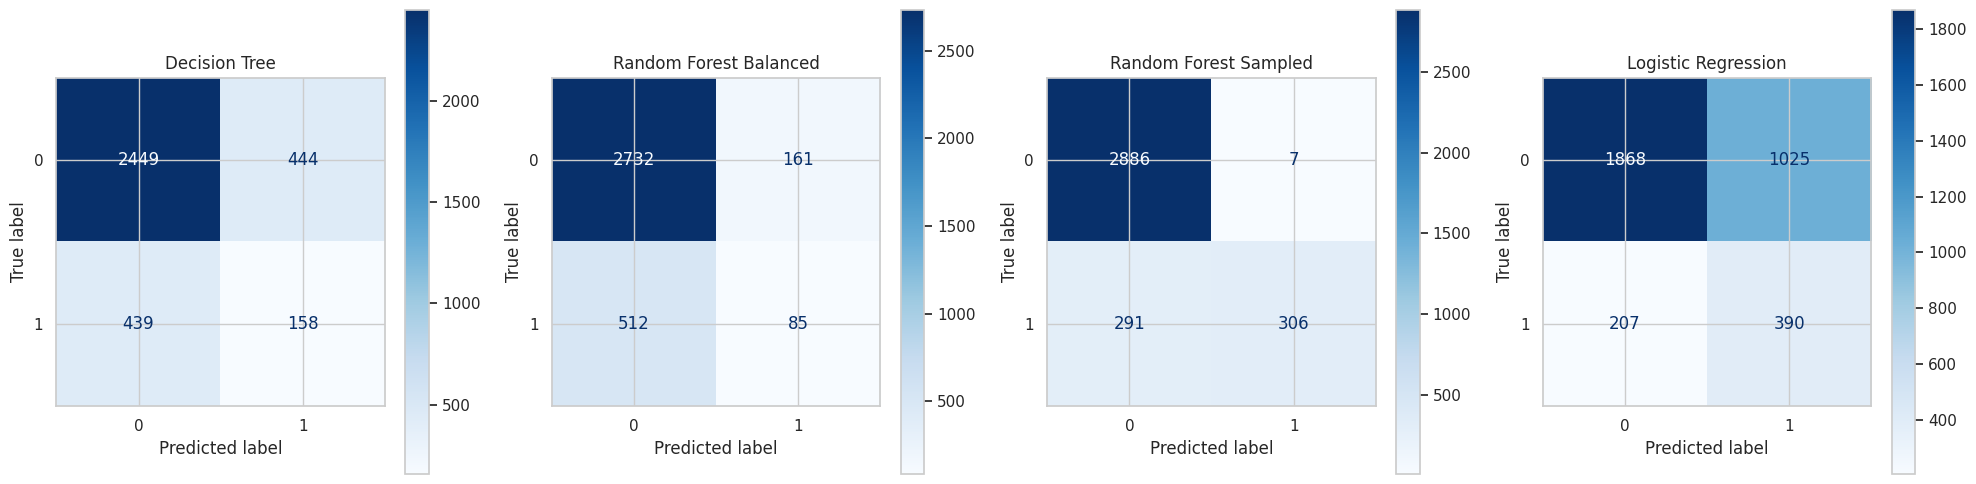

In [ ]:
# --- Decision Tree ---
y_pred_dt = best_dt.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt.classes_)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
disp_dt.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Decision Tree')

# --- Random Forest Balanced ---
y_pred_rf_balanced = best_rf.predict(X_test)
cm_rf_balanced = confusion_matrix(y_test, y_pred_rf_balanced)
disp_rf_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_rf_balanced, display_labels=best_rf.classes_)
disp_rf_balanced.plot(cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title('Random Forest Balanced')

# --- Random Forest Sampled ---
y_pred_rf_sampled = rf_model_resampled.predict(X_test)
cm_rf_sampled = confusion_matrix(y_test, y_pred_rf_sampled)
disp_rf_sampled = ConfusionMatrixDisplay(confusion_matrix=cm_rf_sampled, display_labels=rf_model_resampled.classes_)
disp_rf_sampled.plot(cmap=plt.cm.Blues, ax=ax[2])
ax[2].set_title('Random Forest Sampled')

# --- Logistic Regression ---
y_pred_lr = model.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=model.classes_)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax[3])
ax[3].set_title('Logistic Regression')

plt.tight_layout()
plt.show()

| Modelo             | Prec 1 | Recall 1 | F1 1 | ROC AUC                                       | PR AUC | Razón Elegir                                                        |
| ------------------ | ------ | -------- | ---- | --------------------------------------------- | ------ | ------------------------------------------------------------ |
| RandomForest Balanceado  | 0.42   | 0.82     | 0.56 | 0.66  | 0.30   | Ganador: Mejor discriminación + estable      |
| RandomForest Sampled | 0.28   | 0.54     | 0.37 | 0.64                                             | 0.35   | Baseline bueno                 |
| Decision Tree       | 0.44   | 0.01     | 0.03 | 0.62                                          | 0.24   | Interpretable pero overfit                            |
| Logistic Regression | 0.25   | 0.57     | 0.34 | 0.65                                          | -      | Simple, rápido, menos preciso  |

Comparando los modelos en función de las métricas obtenidas, el modelo **Random Forest Balanceado** demuestra ser superior. Analicemos por qué:

1.  **Mejor Discriminación (ROC AUC)**: con un ROC AUC de **0.66**, este modelo muestra una capacidad superior para distinguir entre vuelos retrasados y puntuales en comparación con los otros modelos. Esto es crucial para un sistema de predicción.

2.  **Balance Óptimo (Recall y Precisión)**: observamos un `Recall 1` de **0.82**, lo que significa que el modelo es muy bueno identificando la mayoría de los vuelos que realmente se van a retrasar (pocos falsos negativos). Aunque su `Precisión 1` es de 0.42, lo que indica que una parte de las predicciones de retraso son falsos positivos, la combinación de ambos, reflejada en un `F1 1` de 0.56, demuestra un balance más robusto, especialmente cuando se busca no perder muchos casos positivos.

3.  **Estabilidad**: la naturaleza de los Random Forests, que construyen múltiples árboles de decisión y agregan sus resultados, tiende a generar modelos más estables y menos propensos al sobreajuste (overfitting) en comparación con un solo Árbol de Decisión.

En resumen, mientras que otros modelos como la Regresión Logística son más rápidos o el Árbol de Decisión es más interpretable, el Random Forest Balanceado ofrece la mejor combinación de discriminación y capacidad para identificar correctamente la clase minoritaria (retrasos), lo que lo convierte en el **ganador** para esta tarea de predicción de retrasos de vuelos.

## Serializando el modelo


El modelo de **Random Forest Balanceado** se guarda con el nombre `MVP_entrenamiento.pkl`.

In [ ]:
try:
  #with open('champion.pkl', 'wb') as file:
  #  pickle.dump(model_grid.best_estimator_, file)
  with open('MVP_entrenamiento.pkl', 'wb') as file:
    joblib.dump(best_rf, file)
  print('Modelo serializado con éxito')
except Exception as e:
  print(f'Se presento un error al almacenar el modelo: {e.str}')
print("Exportado modelo ganador")

Modelo serializado con éxito
Exportado modelo ganador


## **Histograma de probabilidades del modelo ganador (Random Forest Balanceado)**

El siguiente histograma muestra la distribución de las probabilidades predichas por el modelo `Random Forest Balanceado` para el conjunto de prueba (`X_test`). Se visualiza la distribución para ambas clases reales (0: Puntual, 1: Retrasado) para entender la capacidad del modelo para separar estas clases.

Idealmente, querríamos ver las probabilidades para la clase '0' concentradas cerca de 0, y las probabilidades para la clase '1' concentradas cerca de 1. La superposición entre las distribuciones indica la dificultad del modelo para distinguir perfectamente entre las dos clases.

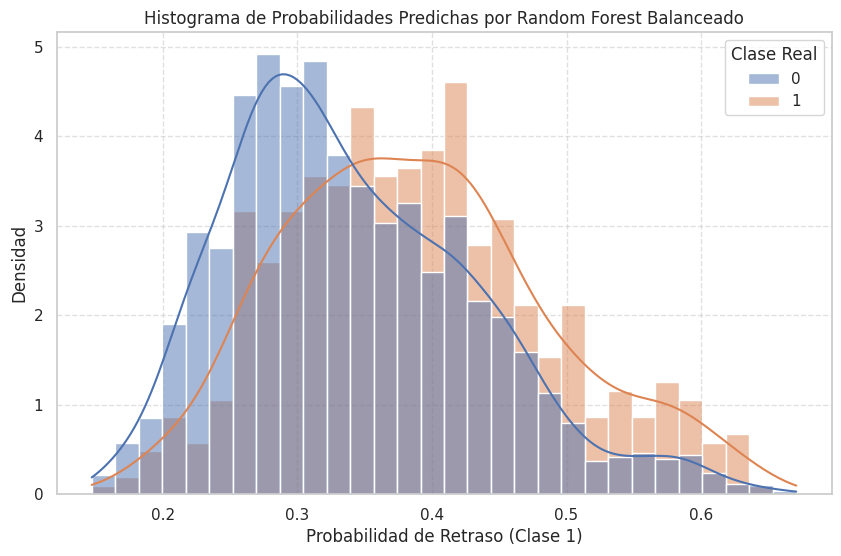

In [ ]:
# Obtener las probabilidades para el modelo Random Forest Balanceado (best_rf)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Crear un DataFrame para facilitar la visualización con seaborn
proba_df = pd.DataFrame({'Probabilidad de Retraso': y_proba_best_rf, 'Clase Real': y_test})

plt.figure(figsize=(10, 6))
sns.histplot(data=proba_df, x='Probabilidad de Retraso', hue='Clase Real', kde=True, stat='density', common_norm=False)
plt.title('Histograma de Probabilidades Predichas por Random Forest Balanceado')
plt.xlabel('Probabilidad de Retraso (Clase 1)')
plt.ylabel('Densidad')
# plt.legend(title='Clase Real') # Se elimina esta línea para evitar el UserWarning
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

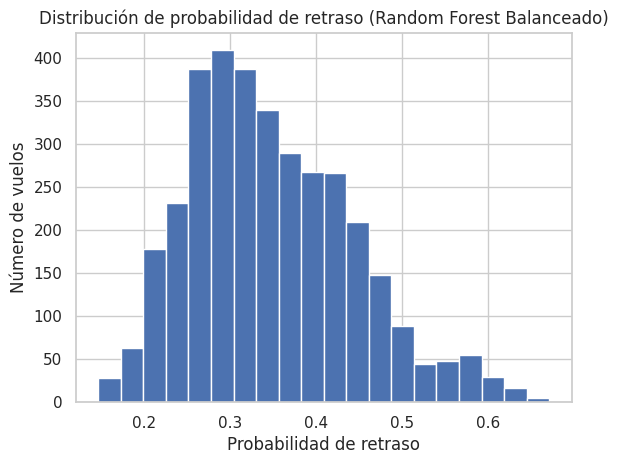

In [ ]:
# Calculamos las probabilidades para el modelo ganador (best_rf)
plt.hist(y_proba_best_rf, bins=20)
plt.title("Distribución de probabilidad de retraso (Random Forest Balanceado)")
plt.xlabel("Probabilidad de retraso")
plt.ylabel("Número de vuelos")
plt.show()

# **🌐 Simulación de endpoint**

Función `predict_flight_delay' define una función que simula cómo un "endpoint" de una API recibiría una solicitud (en formato JSON), preprocesaría los datos de entrada y usaría el modelo entrenado para generar una predicción y una probabilidad de retraso. Se usan valores por defecto para la temperatura, precipitación y velocidad del viento, simulando el enfoque MVP (Producto Mínimo Viable).

In [ ]:
#modelo_champion = pd.read_pickle('/content/MVP_entrenamiento.pkl')
modelo_champion = joblib.load("/content/MVP_entrenamiento.pkl")

In [ ]:
FEATURES = [
    'year','month','dayofmonth','day_of_week','hour',
    'marketing_airline_network','distance','destcityname',
    'airport_code',
    'precipitation','wind_speed','temp_mean' # 'temp' #
]

DEFAULTS = {
    # numéricas (NaN para que el imputador haga su trabajo)
    "year": np.nan, "month": np.nan, "dayofmonth": np.nan,
    "day_of_week": np.nan, "hour": np.nan,
    "distance": np.nan,
    #"temp": np.nan, #
    "temp_mean": np.nan,
    "precipitation": np.nan, "wind_speed": np.nan,
    # categóricas (conviene "unknown" para que OneHotEncoder la trate como categoría; con handle_unknown='ignore' también funciona)
    "marketing_airline_network": "unknown",
    "destcityname": "unknown",
    "airport_code": "unknown"
}

def build_df_input(payload: dict) -> pd.DataFrame:
    # crea 1 fila con defaults
    row = {c: DEFAULTS.get(c, np.nan) for c in FEATURES}

    # completa lo que sí viene
    fecha = pd.to_datetime(payload.get("fecha_partida"))
    if pd.notna(fecha):
        row["year"] = fecha.year
        row["month"] = fecha.month
        row["dayofmonth"] = fecha.day
        row["day_of_week"] = fecha.dayofweek + 1
        row["hour"] = fecha.hour

    if "aerolinea" in payload:
        row["marketing_airline_network"] = payload["aerolinea"]

    if "distancia_km" in payload:
        row["distance"] = payload["distancia_km"] / 1.60934  # si tu entrenamiento usó millas

    # opcionales (si llegan)
    for k in ["precipitation","wind_speed","temp_mean" #,"temp", #
              ,"destcityname", "airport_code"]:
        if k in payload:
            row[k] = payload[k]

    return pd.DataFrame([row], columns=FEATURES)


In [ ]:
# función predicción
# Recibe un JSON
# Devuelve predicción + probabilidad
def predict_flight_delay(input_json, model):
    fecha = pd.to_datetime(input_json["fecha_partida"])     # Convertimos la fecha a datetime

    # Construimos un DataFrame con el mismo esquema del entrenamiento
    df_input = build_df_input(input_json)
    # La siguiente línea era incorrecta y ha sido eliminada. El preprocesador ya está ajustado dentro del pipeline 'model'.
    # Xt = model.named_steps["preprocess"].fit_transform(X_train, y_train)

    # Las siguientes líneas de impresión también han sido eliminadas por ser parte del diagnóstico incorrecto.
    # if sparse.issparse(Xt):
    #     print("No finitos en Xt.data:", np.isfinite(Xt.data).sum() != Xt.data.size)
    #     print("Cantidad no finitos:", (~np.isfinite(Xt.data)).sum())
    # else:
    #     print("Cantidad no finitos:", (~np.isfinite(Xt)).sum())


    # predicción
    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

Se muestra un `input_example` con datos de un vuelo simulado y se llama a la función `predict_flight_delay` para obtener una predicción, imprimiendo la respuesta.

In [ ]:
# Simulamos

input_example = {
    "aerolinea": "AA",
    "fecha_partida": "2025-11-10T14:30:00",
    "distancia_km": 850
}

# La variable 'modelo_champion' ya se carga desde 'MVP_entrenamiento.pkl' en la celda anterior.
# 'MVP_entrenamiento.pkl' contiene el 'Random Forest Balanceado' (best_rf).

# Realizar la predicción
predict_flight_delay(input_example, modelo_champion)

{'prevision': 'Puntual', 'probabilidad': 0.3}

En esa sección:

*   Se define una lista de *inputs* (cuatro vuelos simulados diferentes) para demostrar cómo la función de predicción respondería a múltiples solicitudes.

*   Se itera sobre la lista de *inputs*, se llama a `predict_flight_delay` para cada uno y se almacenan los resultados (vuelo, aerolínea, probabilidad de retraso y previsión final) en una lista *results*.

*   Finalmente, la lista *results* se convierte en un DataFrame (`df_results`) y se utiliza para crear un gráfico de barras. Este gráfico muestra la probabilidad de retraso para cada vuelo simulado, con etiquetas de texto indicando si la previsión final es "**Puntual**" o "**Retrasado**", lo que simula visualmente la respuesta de un sistema en producción.

In [ ]:
#Llamamos al endpoint varias veces

inputs = [
    {
        "aerolinea": "AZ",
        "fecha_partida": "2025-11-10T08:30:00",
        "distancia_km": 300
    },
    {
        "aerolinea": "F9",
        "fecha_partida": "2025-11-10T19:45:00",
        "distancia_km": 1200
    },
    {
        "aerolinea": "AA",
        "fecha_partida": "2025-11-10T06:15:00",
        "distancia_km": 800
    },
    {
        "aerolinea": "NK",
        "fecha_partida": "2025-11-10T22:10:00",
        "distancia_km": 1500
    }
]

results = []

for i, inp in enumerate(inputs):
    response = predict_flight_delay(inp, model)
    results.append({
        "vuelo": f"Vuelo {i+1}",
        "aerolinea": inp["aerolinea"],
        "probabilidad": response["probabilidad"],
        "prevision": response["prevision"]
    })

df_results = pd.DataFrame(results)
df_results

,vuelo,aerolinea,probabilidad,prevision
0,Vuelo 1,AZ,0.35,Puntual
1,Vuelo 2,F9,0.59,Retrasado
2,Vuelo 3,AA,0.28,Puntual
3,Vuelo 4,NK,0.61,Retrasado


# **📋 Resumen general**
---


Aunque el **Logistic Regresion** se mantiene como modelo base, el **Random Forest Balanceado** se elige como modelo final recomendado para producción, ya que mantiene un mejor equilibrio entre la precisión y la capacidad de identificar retrasos.

Justificación:

1.   Captura relaciones no lineales:

*   El efecto de la hora, el clima y la distancia no es lineal.
*   Random Forest captura automáticamente interacciones complejas sin necesidad de ingeniería manual de variables.

2.  Mejor aprovechamiento del dataset ampliado:

*   El aumento de ciudades y vuelos beneficia especialmente a modelos basados en árboles.
*   Cada árbol aprende patrones distintos y el conjunto generaliza mejor.

3.  Mejor equilibrio entre *recall* y precision:

*   Detecta mejor vuelos con riesgo de retraso.
*   Reduce falsos negativos, que tienen mayor coste operativo.

4.  Mayor robustez:

*   Menos sensible a ruido y valores extremos en los retrasos.
*   Comportamiento más estable en escenarios reales.

5.   Mantiene el enfoque MVP:

*   No cambia el *pipeline*.
*   No cambia el formato de entrada JSON.
*   No añade complejidad al backend.

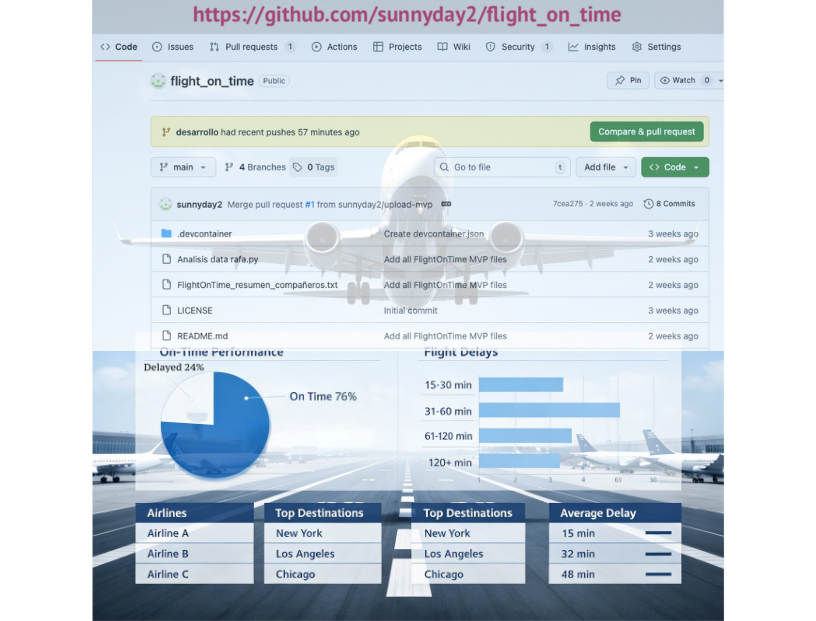